In [15]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from nltk.tokenize import sent_tokenize
import gensim.parsing.preprocessing as gen_preproc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm')

import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1 )

basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,4,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,3,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,2,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,3,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


In [3]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1 )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,2,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,3,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,4,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,2,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,4,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


In [ ]:
df['label'] = df['label'].apply(lambda x: float(x))
test_df['label'] = test_df['label'].apply(lambda x: float(x))
df.head()

In [4]:
maxNumWords = 5000 #Most frequent
maxSeqLeng = 45 #See Initial Models file for reviews length distro justifying this. 
embedDim = 100
epochs = 10
batch_size = 64

In [5]:
tokenizer = Tokenizer( num_words=maxNumWords ) #already did other preproc, but could include more here
tokenizer.fit_on_texts(df['lemmatized'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12724 unique tokens.


In [6]:
X = tokenizer.texts_to_sequences( df['lemmatized'].values )
X = pad_sequences( X, maxlen=maxSeqLeng) #Adds 0's in front of my sentances that are shorter than maxSeqLen
Y = np.array( list( df['label'] ) )

In [9]:
opt = keras.optimizers.Adam(learning_rate=0.0003) 
embedDim = 100
epochs = 100

modelMCCrossEntropyFull = Sequential()
modelMCCrossEntropyFull.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelMCCrossEntropyFull.add(SpatialDropout1D(0.2))
modelMCCrossEntropyFull.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelMCCrossEntropyFull.add(Dense(5, activation='softmax'))
modelMCCrossEntropyFull.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['mean_squared_error']) 
print(modelMCCrossEntropyFull.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 45, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 580,905
Trainable params: 580,905
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
from keras.utils import to_categorical
YMultiClass = to_categorical(Y)

history = modelMCCrossEntropyFull.fit(X, YMultiClass, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
121/121 [==============================] - 11s 92ms/step - loss: 1.5735 - mean_squared_error: 0.1572 - val_loss: 1.6167 - val_mean_squared_error: 0.1603
Epoch 2/100
121/121 [==============================] - 11s 88ms/step - loss: 1.5483 - mean_squared_error: 0.1551 - val_loss: 1.6102 - val_mean_squared_error: 0.1597
Epoch 3/100
121/121 [==============================] - 10s 84ms/step - loss: 1.4606 - mean_squared_error: 0.1479 - val_loss: 1.5785 - val_mean_squared_error: 0.1577
Epoch 4/100
121/121 [==============================] - 11s 93ms/step - loss: 1.2956 - mean_squared_error: 0.1345 - val_loss: 1.5396 - val_mean_squared_error: 0.1554
Epoch 5/100
121/121 [==============================] - 10s 83ms/step - loss: 1.1601 - mean_squared_error: 0.1225 - val_loss: 1.3882 - val_mean_squared_error: 0.1435
Epoch 6/100
121/121 [==============================] - 10s 83ms/step - loss: 1.0641 - mean_squared_error: 0.1135 - val_loss: 1.4108 - val_mean_squared_error: 0.1465
Epoch 7/10

In [16]:
test_X = tokenizer.texts_to_sequences( test_df['lemmatized'].values )
test_X = pad_sequences( test_X, maxlen=maxSeqLeng)

In [18]:
predict_Y = modelMCCrossEntropyFull.predict( test_X )
predict_Y = np.argmax(predict_Y, axis=1)

test_df['label'] = test_df['label'].apply(lambda x: int(x))
true_Y = list( test_df['label'] )

0.3606334841628959


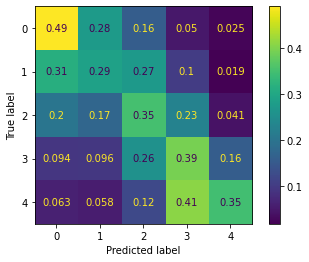

In [21]:
print( accuracy_score( true_Y , predict_Y ) )

MulticlassCM = confusion_matrix( true_Y, predict_Y, normalize='true' )
MultiClassDisp = ConfusionMatrixDisplay( MulticlassCM )
MultiClassDisp.plot()

In [11]:
g = df.groupby('label')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
g.head()

label                                               text  \
label                                                               
0     0      0  Starts out strongly before quickly losing its ...   
      1      0  A period story about a Catholic boy who tries ...   
      2      0  The following things are not at all entertaini...   
      3      0  This overproduced piece of dreck is shockingly...   
      4      0  It just did n't mean much to me and played too...   

                                                 basicProc  \
label                                                        
0     0  starts out strongly before quickly losing its ...   
      1  a period story about a catholic boy who tries ...   
      2  the following things are not at all entertaini...   
      3  this overproduced piece of dreck is shockingly...   
      4  it just did n t mean much to me and played too...   

                                                   stemmed  \
label                                                        
0     0  start out strongli befor quickli lose it focu ...   
      1  a period stori about a cathol boi who tri to h...   
      2  the follow thing ar not at all entertain the b...   
      3  thi overproduc piec of dreck is shockingli bad...   
      4  it just did n t mean much to me and plai too s...   

                                                lemmatized  
label                                                       
0     0  start out strongly before quickly lose -PRON- ...  
      1  a period story about a catholic boy who try to...  
      2  the follow thing be not at all entertain the b...  
      3  this overproduced piece of dreck be shockingly...  
      4  -PRON- just do n t mean much to -PRON- and pla...

In [12]:
modelBalLabels = Sequential()
modelBalLabels.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelBalLabels.add(SpatialDropout1D(0.2))
modelBalLabels.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelBalLabels.add(Dense(5, activation='softmax'))
modelBalLabels.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['mean_squared_error']) 
print(modelBalLabels.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 45, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 580,905
Trainable params: 580,905
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
XBal = tokenizer.texts_to_sequences( g['lemmatized'].values )
XBal = pad_sequences( XBal, maxlen=maxSeqLeng) #Adds 0's in front of my sentances that are shorter than maxSeqLen
YBal = np.array( list( g['label'] ) )

In [35]:
from keras.utils import to_categorical
YMultiClassBal = to_categorical(YBal)

history = modelBalLabels.fit(XBal, YMultiClassBal, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
77/77 [==============================] - 7s 94ms/step - loss: 1.5785 - mean_squared_error: 0.1578 - val_loss: 1.9579 - val_mean_squared_error: 0.1840
Epoch 2/100
77/77 [==============================] - 7s 88ms/step - loss: 1.4164 - mean_squared_error: 0.1455 - val_loss: 1.7221 - val_mean_squared_error: 0.1667
Epoch 3/100
77/77 [==============================] - 7s 96ms/step - loss: 1.1925 - mean_squared_error: 0.1269 - val_loss: 1.9569 - val_mean_squared_error: 0.1860
Epoch 4/100
77/77 [==============================] - 7s 95ms/step - loss: 1.0176 - mean_squared_error: 0.1094 - val_loss: 2.0191 - val_mean_squared_error: 0.1757
Epoch 5/100
77/77 [==============================] - 7s 86ms/step - loss: 0.8696 - mean_squared_error: 0.0935 - val_loss: 2.1418 - val_mean_squared_error: 0.1908


In [36]:
predict_Y_bal = modelBalLabels.predict( test_X )
predict_Y_bal = np.argmax(predict_Y_bal, axis=1)

0.3561085972850679


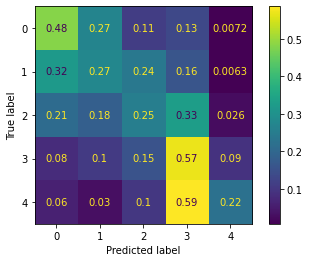

In [37]:
print( accuracy_score( true_Y , predict_Y_bal ) )

MulticlassCMBal = confusion_matrix( true_Y, predict_Y_bal, normalize='true' )
MultiClassDispBal = ConfusionMatrixDisplay( MulticlassCMBal )
MultiClassDispBal.plot()

### First, train the LSTMs 
Training is supervised prediction of output category. Here the LSTM with unbalanced classes performs slightly better than the one with balanced classes in the full supervised learning. So we then go backwards & grab the weights / embeddings from the supervised LSTM with unbalanced classes. 

## Start with Matrices

Currently using X, so using unbalanced data for training the later XG boost.

In [25]:
word_embds = modelMCCrossEntropyFull.layers[0].get_weights()

embeds_X = word_embds[0][X] #A full matrix for every tweet. 
embeds_X = np.array( [np.array(x).flatten() for x in embeds_X] )

In [26]:
mat_model = xgb.XGBClassifier(use_label_encoder=False)
mat_model.fit( embeds_X , Y )

[23:39:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
embeds_X_test = word_embds[0][test_X]
embeds_X_test = np.array( [np.array(x).flatten() for x in embeds_X_test] )
embeds_Y_predict = mat_model.predict( embeds_X_test )

0.3583710407239819


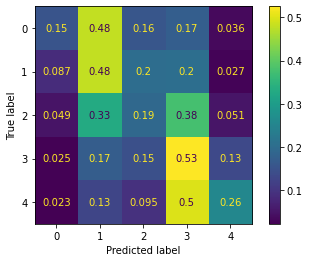

In [29]:
print( accuracy_score( true_Y , embeds_Y_predict ) )

XGCM = confusion_matrix( true_Y, embeds_Y_predict, normalize='true' )
XGDisp = ConfusionMatrixDisplay( XGCM )
XGDisp.plot()

## Vecs Model
Reverse the mask / delete the padding so my vectors aren't averaging with a bunch of vectors representing the pad-vector

In [30]:
unmasked_X = np.array( [ np.array(x[x != 0]) for x in X ] )

C:\Users\601969\AppData\Local\Temp\1/ipykernel_792/3378909577.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  unmasked_X = np.array( [ np.array(x[x != 0]) for x in X ] )


In [31]:
def calc_vec(x, word_embds):
    vecs = word_embds[0][x]
    if len(x) == 0:
        vecs = [np.zeros(100), np.zeros(100)]
    return sum(vecs) / max([len(x), 1])

vecs_embeds_X = np.array( [calc_vec(x, word_embds) for x in unmasked_X] )

In [32]:
vecs_model = xgb.XGBClassifier(use_label_encoder=False)
vecs_model.fit( vecs_embeds_X , Y )

[23:47:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [33]:
test_unmasked_X = np.array( [ np.array(x[x != 0]) for x in test_X ] )
test_vecs_embeds_X = np.array( [calc_vec(x, word_embds) for x in test_unmasked_X] )

vecs_embeds_Y_predict = vecs_model.predict( test_vecs_embeds_X )

C:\Users\601969\AppData\Local\Temp\1/ipykernel_792/228062908.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_unmasked_X = np.array( [ np.array(x[x != 0]) for x in test_X ] )


0.39592760180995473


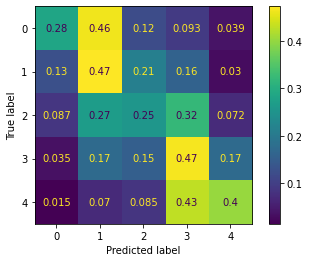

In [34]:
print( accuracy_score( true_Y , vecs_embeds_Y_predict ) )

XGVecsCM = confusion_matrix( true_Y, vecs_embeds_Y_predict, normalize='true' )
XGVecsDisp = ConfusionMatrixDisplay( XGVecsCM )
XGVecsDisp.plot()

### Now using Balanced 
Grab the embedding vectors of only the balanced labels

In [38]:
embeds_XBal = word_embds[0][XBal] #A full matrix for every tweet. 
embeds_XBal = np.array( [np.array(x).flatten() for x in embeds_XBal] )

In [40]:
mat_model_bal = xgb.XGBClassifier(use_label_encoder=False)
mat_model_bal.fit( embeds_XBal , YBal )

[14:52:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [41]:
embeds_YBal_predict = mat_model_bal.predict( embeds_X_test )

0.32850678733031674


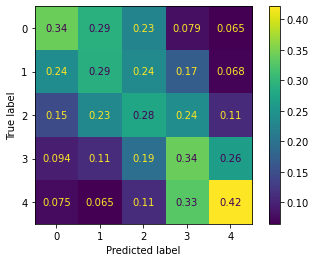

In [42]:
print( accuracy_score( true_Y , embeds_YBal_predict ) )

XGBalCM = confusion_matrix( true_Y, embeds_YBal_predict, normalize='true' )
XGBalDisp = ConfusionMatrixDisplay( XGBalCM )
XGBalDisp.plot()

### Vecs Balanced X

In [43]:
unmasked_XBal = np.array( [ np.array(x[x != 0]) for x in XBal ] )

C:\Users\601969\AppData\Local\Temp\1/ipykernel_792/3254801051.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  unmasked_XBal = np.array( [ np.array(x[x != 0]) for x in XBal ] )


In [44]:
vecs_embeds_XBal = np.array( [calc_vec(x, word_embds) for x in unmasked_XBal] )

In [45]:
vecs_bal_model = xgb.XGBClassifier(use_label_encoder=False)
vecs_bal_model.fit( vecs_embeds_XBal , YBal )

[14:56:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [46]:
vecs_embeds_YBal_predict = vecs_bal_model.predict( test_vecs_embeds_X )

0.3723981900452489


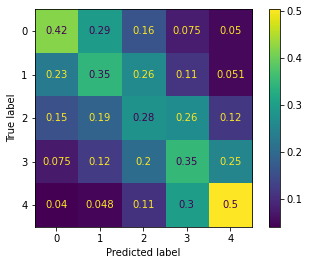

In [47]:
print( accuracy_score( true_Y , vecs_embeds_YBal_predict ) )

XGVecsBalCM = confusion_matrix( true_Y, vecs_embeds_YBal_predict, normalize='true' )
XGVecsBalDisp = ConfusionMatrixDisplay( XGVecsBalCM )
XGVecsBalDisp.plot()